In [30]:
# !sudo pip3 install gdown
!cd ramdisk && gdown "https://drive.google.com/uc?id=1--AIxkesHEW-VIBveNVJpYWdsKk3gFbI"
#!wget "https://doc-0g-90-docs.googleusercontent.com/docs/securesc/b5le5ac2gbddk9d214ag7igpnum314v8/lf4o5ds7302adeg5b6l1snq34kg7gtm5/1576706400000/05082288337558079316/05082288337558079316/1--AIxkesHEW-VIBveNVJpYWdsKk3gFbI?e=download&authuser=0&nonce=onc3f173h31pa&user=05082288337558079316&hash=g5mcs3pp99lf8nj84p0rglqfsns436c9"

Downloading...
From: https://drive.google.com/uc?id=1--AIxkesHEW-VIBveNVJpYWdsKk3gFbI
To: /home/dylan/ramdisk/cropped.zip
619MB [00:06, 95.6MB/s] 


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip /content/drive/My\ Drive/traffic_images.zip

In [49]:
import os
import numpy as np
import PIL.Image as Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as functional
import matplotlib.pyplot as plt

DATA_PATH = "ramdisk/disk"  # path to cropped images
TEST_PATH = "ramdisk/spliced"  # path to cropped images
HEIGHT = 2710
WIDTH = 3384
RESIZE_H = 80
RESIZE_W = 120
batch_size=512

In [50]:
test_set = MyDataset(TEST_PATH, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [32]:
class MyDataset(Dataset):
    def __init__(self, input_dir, transform=None):
        self.transform = transform
        self.DIR = input_dir
        self.list_files = [name for name in os.listdir(self.DIR)]

    def __len__(self):
        return len([name for name in os.listdir(self.DIR) if os.path.isfile(os.path.join(self.DIR, name))])

    def __getitem__(self, idx):
        img_path = os.path.join(self.DIR, self.list_files[idx])
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.list_files[idx]  # return image and its name (ID)

transform = torchvision.transforms.Compose(
                    [torchvision.transforms.Grayscale(),
                    torchvision.transforms.Resize((RESIZE_H, RESIZE_W)),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.ToTensor()])

train_set = MyDataset(DATA_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)

In [33]:
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.intermediate = 256

    # Apply convolutions to reduce into a more tractable form.
    self.conv_spatial1 = torch.nn.Sequential(
      torch.nn.Conv2d(1, 32, kernel_size=6, stride=2, padding=0),
      torch.nn.LeakyReLU(),
      torch.nn.Conv2d(32, 16, kernel_size=7, stride=1, padding=0),
      torch.nn.LeakyReLU(),
      torch.nn.Conv2d(16, 3, kernel_size=7, stride=1, padding=0),
      torch.nn.LeakyReLU()
    )
    self.out = 3 * 26 * 46

    # Encode our image into a single vector
    self._encode = torch.nn.Sequential(
        torch.nn.Linear(self.out, self.intermediate),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(self.intermediate, self.intermediate//2),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(self.intermediate//2, self.intermediate//4),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(self.intermediate//4, self.intermediate//8),
        torch.nn.LeakyReLU(),
        torch.nn.BatchNorm1d(self.intermediate//8)
    )

    # Decode our vector into
    self._decode = torch.nn.Sequential(
        torch.nn.Linear(self.intermediate//8, self.intermediate//4),
        torch.nn.LeakyReLU(), 
        torch.nn.Linear(self.intermediate//4, self.intermediate//2),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(self.intermediate//2, self.intermediate),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(self.intermediate, self.out),
        torch.nn.BatchNorm1d(self.out)
    )

    # Provide another convolution to our data.
    self.conv_spatial2 = torch.nn.Sequential(
      torch.nn.ConvTranspose2d(3, 16, kernel_size=7, stride=1, padding=0),
      torch.nn.LeakyReLU(),
      torch.nn.ConvTranspose2d(16, 32, kernel_size=7, stride=1, padding=0),
      torch.nn.LeakyReLU(),
      torch.nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2, padding=0),
      torch.nn.LeakyReLU()
    )

  def encode(self, x):
    x = self.conv_spatial1(x)
    x = x.view(-1, self.out)
    return self._encode(x)

  def decode(self, z):
    z = self._decode(z)
    z = z.view(-1, 3, 26, 46)
    z = self.conv_spatial2(z)
    return z.view(-1, 1, 80, 120)

  def forward(self, x):
    return self.decode(self.encode(x))

In [34]:
class AutoEncoder2(torch.nn.Module):
  def __init__(self):
    super(AutoEncoder2, self).__init__()
    self.intermediate = 256

    # Encode our image into a single vector
    self._encode = torch.nn.Sequential(
        torch.nn.Linear(80*120, 4096),
        torch.nn.BatchNorm1d(4096),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(4096, 2048),
        torch.nn.BatchNorm1d(2048),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(2048, 1024)
        # torch.nn.BatchNorm1d(1024),
        # torch.nn.LeakyReLU(),
        # torch.nn.Linear(1024, 512)
    )

    # Decode our vector into
    self._decode = torch.nn.Sequential(
        # torch.nn.Linear(512, 1024),
        # torch.nn.BatchNorm1d(1024),
        # torch.nn.LeakyReLU(),
        torch.nn.Linear(1024, 2048),
        torch.nn.BatchNorm1d(2048),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(2048, 4096),
        torch.nn.BatchNorm1d(4096),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(4096, 80*120)
    )

  def encode(self, x):
    x = x.view(-1, 80*120)
    return self._encode(x)

  def decode(self, z):
    z = self._decode(z)
    return z.view(-1, 1, 80, 120)

  def forward(self, x):
    return self.decode(self.encode(x))

In [5]:
def _run(net, epochs, learning_rate, optimizer, scheduler, debug, loss, augmentations,
         train_losses, train_accuracy, eval_losses, eval_accuracy, loader, batch_size=batch_size):
  for epoch in range(epochs):

    epoch_loss = 0
    total = 0
    for i, data in enumerate(loader, 0):

      inputs, _ = data
      inputs *= 255.0
      labels = inputs
      optimizer.zero_grad()

      inputs = torch.autograd.Variable(inputs, requires_grad=False).cuda()
      labels = torch.autograd.Variable(labels, requires_grad=False).cuda()

      outputs = net(inputs)
      loss_size = loss(outputs, labels)
      loss_size.backward()
      optimizer.step()
      scheduler.step()

      epoch_loss += loss_size.data
      total += batch_size
      print(loss_size.data / batch_size)

    train_losses.append(epoch_loss / total)

    if debug:
      print("Epoch: {}".format(epoch))
      print("Train Loss: {}".format(train_losses[-1]))

def run(net, epochs=20, learning_rate=1e-2, optimizer=torch.optim.Adam,
        scheduler=torch.optim.lr_scheduler.StepLR, debug=True, 
        loader=train_loader, loss=torch.nn.MSELoss):
  net.train()
  loss = loss()
  optimizer = optimizer(net.parameters(), lr=learning_rate)
  scheduler = scheduler(optimizer, step_size=20, gamma=0.9)

  # Augmentations
  augmentations = None

  train_losses = []
  train_accuracy = []

  eval_losses = []
  eval_accuracy = []
  try:
    _run(net, epochs, learning_rate, optimizer, scheduler, debug, loss, augmentations,
         train_losses, train_accuracy, eval_losses, eval_accuracy, loader)
  except KeyboardInterrupt:
    pass
  return train_losses, train_accuracy, eval_losses, eval_accuracy

In [40]:
model = torch.load("ramdisk/pretrained_AE.pt")

In [41]:
autoencoder = model

tensor(20.1997, device='cuda:0')
tensor(15.0077, device='cuda:0')
tensor(13.3293, device='cuda:0')
tensor(8.8785, device='cuda:0')
tensor(6.0523, device='cuda:0')
tensor(5.6214, device='cuda:0')
tensor(5.6213, device='cuda:0')
tensor(5.9302, device='cuda:0')
tensor(5.9547, device='cuda:0')
tensor(6.2814, device='cuda:0')
tensor(6.1871, device='cuda:0')
tensor(5.6852, device='cuda:0')
tensor(5.5190, device='cuda:0')
tensor(5.1046, device='cuda:0')
tensor(5.3050, device='cuda:0')
tensor(4.9053, device='cuda:0')
tensor(4.7712, device='cuda:0')
tensor(4.8646, device='cuda:0')
tensor(5.2086, device='cuda:0')
tensor(5.0503, device='cuda:0')
tensor(4.7561, device='cuda:0')
tensor(4.8169, device='cuda:0')
tensor(5.2122, device='cuda:0')
tensor(5.0082, device='cuda:0')
tensor(4.9937, device='cuda:0')
tensor(4.9990, device='cuda:0')
tensor(5.0896, device='cuda:0')
tensor(4.9954, device='cuda:0')
tensor(4.7549, device='cuda:0')
tensor(4.8224, device='cuda:0')
tensor(4.7901, device='cuda:0')
tenso

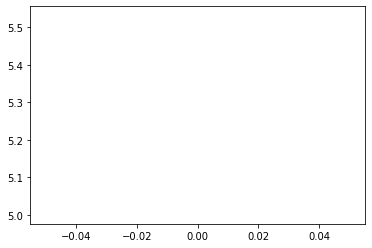

In [43]:
torch.cuda.empty_cache()
autoencoder = AutoEncoder2()
train_losses, train_accuracy, eval_losses, eval_accuracy = run(autoencoder.cuda(), loader=train_loader)
plt.plot(train_losses)
plt.show()

In [10]:
model_save_name = 'pretrained_tuned_AE.pt'
path = F"{model_save_name}" 
torch.save(autoencoder.state_dict(), path)

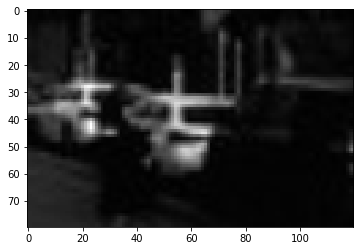

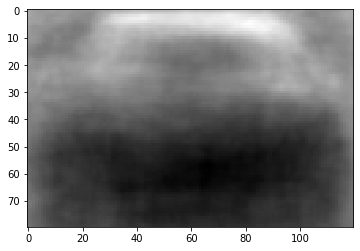

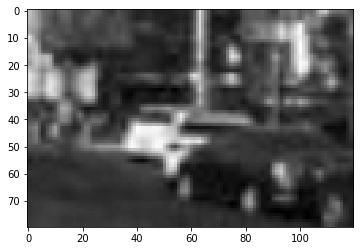

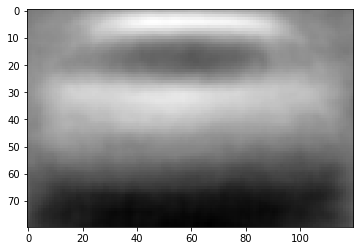

tensor(4.7729, device='cuda:0', grad_fn=<DivBackward0>)


In [52]:
for data in test_loader:
  autoencoder.eval()

  inputs, _ = data
  inputs *= 255.0
  inputs = torch.autograd.Variable(inputs, requires_grad=False).cuda()
  labels = inputs

  x = torch.autograd.Variable(inputs).cuda()
  outputs = autoencoder(x)
  ind = np.random.randint(0, 128, size=2)
  plt.imshow(inputs[ind[0],:,:,:].cpu().squeeze(), cmap='gray')
  plt.show()
  plt.imshow(outputs[ind[0],:,:,:].cpu().detach().squeeze().numpy(), cmap='gray')
  plt.show()
  plt.imshow(inputs[ind[1],:,:,:].cpu().squeeze(), cmap='gray')
  plt.show()
  plt.imshow(outputs[ind[1],:,:,:].cpu().detach().squeeze().numpy(), cmap='gray')
  plt.show()

  loss = torch.nn.MSELoss()
  print(loss(outputs, labels) / batch_size)
  break

In [2]:
import csv
import numpy as np
x = []
with open('ramdisk/embedded_data_training.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    x.append([float(n) for n in row])

training = np.asarray(x)

50876416

In [4]:
import csv
import numpy as np
x = []
with open('ramdisk/embedded_data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter = ' ')
  for row in reader:
    x.append([float(n) for n in row])

test = np.asarray(x)

In [ ]:
import pandas as pd

pd.load

In [53]:
# Save the embedded data and their ids in separate files
train_loader = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=batch_size)

f = open(F'ramdisk/embedded_data_training.csv','ab')
ids = ()
for i, data in enumerate(train_loader, 0):
  print(i)
  autoencoder.eval()
  inputs, names = data
  inputs *= 255.0
  inputs = torch.autograd.Variable(inputs, requires_grad=False).cuda()

  x = torch.autograd.Variable(inputs).cuda()
  embedded = autoencoder.encode(x)
  embedded = embedded.detach().cpu().numpy()
  np.savetxt(f, embedded)

  ids += names

f.close()

g = open(F'ramdisk/ID_training.txt','a')
for i in ids:
    g.write(i+'\n')
g.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
